# Single Dimension Cluster Modeling

#### Load data

In [1]:
import pandas as pd

df = pd.read_csv('chat.csv')

display(df.head())

,timestamp,user,text,date,time
0,2023-08-09 16:57:00,NaN,As mensagens e as ligações são protegidas com ...,2023-08-09,16:57:00
1,2023-07-19 14:34:00,Luis,Aguardando mensagem,2023-07-19,14:34:00
2,2023-07-19 14:26:00,hanna,Aguardando mensagem,2023-07-19,14:26:00
3,2023-07-19 14:46:00,Luis,Aguardando mensagem,2023-07-19,14:46:00
4,2023-07-19 14:46:00,Luis,Aguardando mensagem,2023-07-19,14:46:00


#### Clean data

In [2]:
# Drop missing values for user
df = df.dropna(subset=['user'])

# Convert timestamps to datetime
df.loc[:, 'timestamp'] = pd.to_datetime(df['timestamp'])

# Display timestamps
display(df['timestamp'])

1        2023-07-19 14:34:00
2        2023-07-19 14:26:00
3        2023-07-19 14:46:00
4        2023-07-19 14:46:00
5        2023-07-19 14:46:00
                ...         
52454    2024-05-08 18:02:00
52455    2024-05-08 18:03:00
52456    2024-05-08 18:03:00
52457    2024-05-08 18:03:00
52458    2024-05-08 18:20:00
Name: timestamp, Length: 51997, dtype: object

---
# Feature Engineering

#### Normalized Unix timestamp

In [3]:
df['uuid'] = df['timestamp'].apply(lambda d: d.value)
df['uuid'] = (df['uuid'] - df['uuid'].min()) / (df['uuid'].max() - df['uuid'].min()) # Min-Max Scaling

df['uuid']

1        0.000019
2        0.000000
3        0.000047
4        0.000047
5        0.000047
           ...   
52454    0.999958
52455    0.999960
52456    0.999960
52457    0.999960
52458    1.000000
Name: uuid, Length: 51997, dtype: float64

#### Visualize first messages agains normalized time

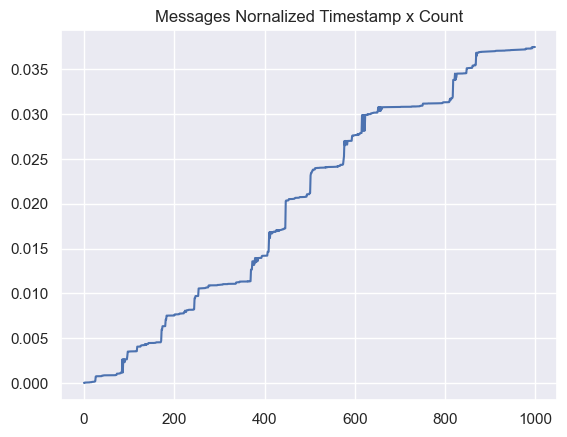

In [8]:
import seaborn as sns; sns.set()

ax = df['uuid'].iloc[:1000].reset_index(drop=True).plot(title="Messages Nornalized Timestamp x Count")

---
## Fit cluster algorithms

#### Optimize the bandwidth

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score

def compute_inertia(X, labels, cluster_centers):
    inertia = 0
    for i, center in enumerate(cluster_centers):
        cluster_points = X[labels == i]
        inertia += np.sum((cluster_points - center) ** 2)
    return inertia

# Get sample data
X = df[['uuid']].values[:1000]

# Define a range of bandwidth values to try
bandwidths = np.linspace(0.0000001, 0.000002, 20)
best_bandwidth_silhouette = None
best_silhouette_score = -1
best_bandwidth_inertia = None
best_inertia = float('inf')

silhouette_scores = []
inertias = []
n_clusters = []

# Iterate over bandwidth values to find the best one
for i, bandwidth in enumerate(bandwidths):
    print(f'{i}/{len(bandwidths)} - Steps DBSCAN Optimization', end='\r')
    meanshift = MeanShift(bandwidth=bandwidth)
    labels = meanshift.fit_predict(X)
    cluster_centers = meanshift.cluster_centers_
    n_clusters.append(len(np.unique(labels)))
    
    if len(np.unique(labels)) > 1:  # Silhouette score is not defined for a single cluster
        score = silhouette_score(X, labels)
        silhouette_scores.append(score)
        if score > best_silhouette_score:
            best_silhouette_score = score
            best_bandwidth_silhouette = bandwidth
    else:
        silhouette_scores.append(-1)  # Indicate that this bandwidth didn't work well
    
    inertia = compute_inertia(X, labels, cluster_centers)
    inertias.append(inertia)
    if inertia < best_inertia:
        best_inertia = inertia
        best_bandwidth_inertia = bandwidth
    print(f'{i + 1}/{len(bandwidths)} - Steps DBSCAN Optimization', end='\r')

#### Display Results

Best bandwidth (Silhouette Score): 1e-07
Best Silhouette score: 0.814
Best bandwidth (Inertia): 1e-07
Best Inertia: 1.0142047709459614e-33



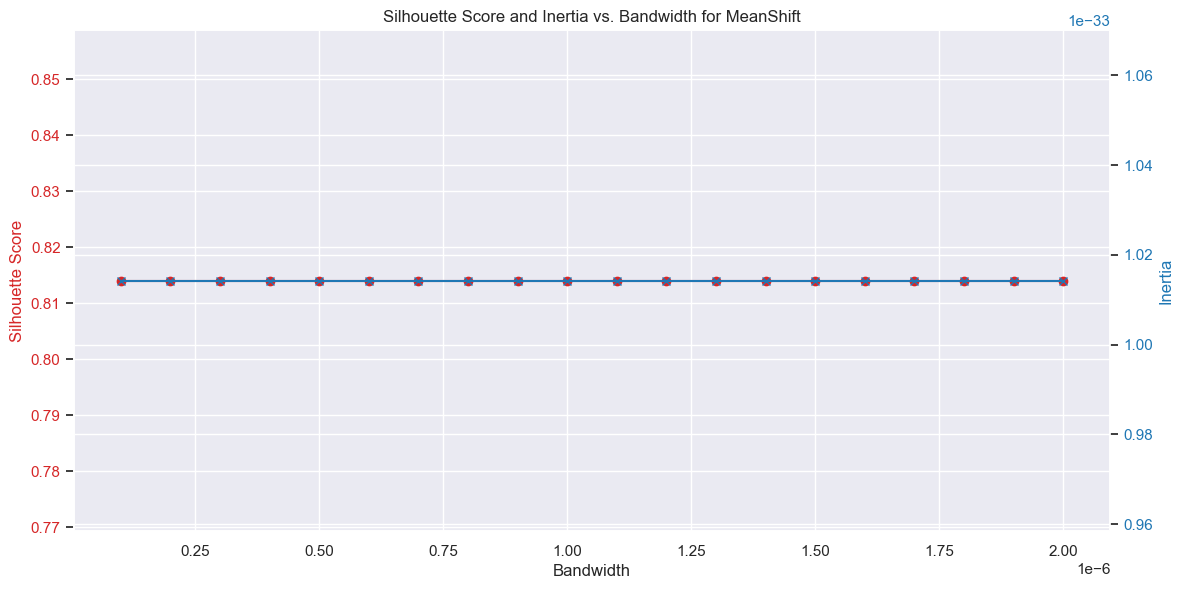

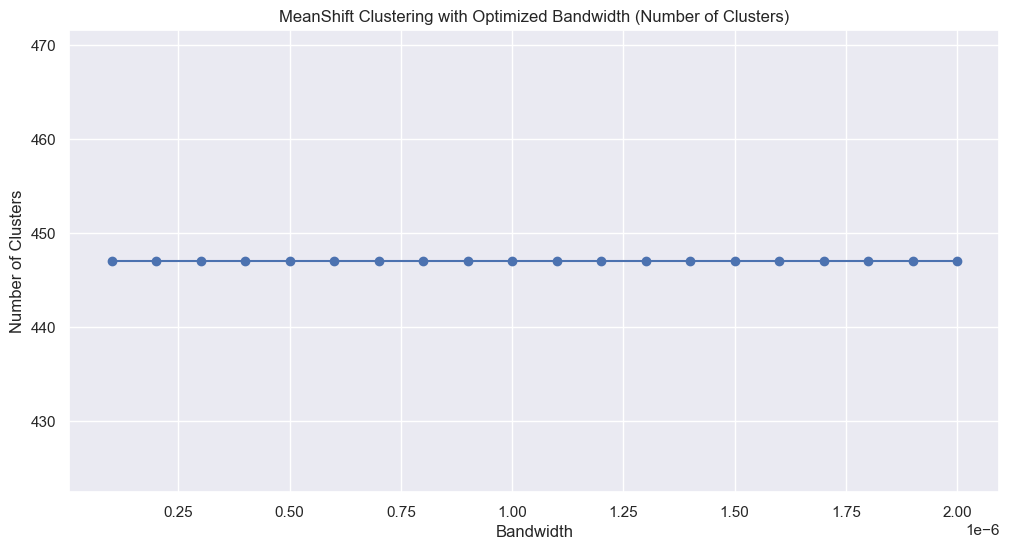

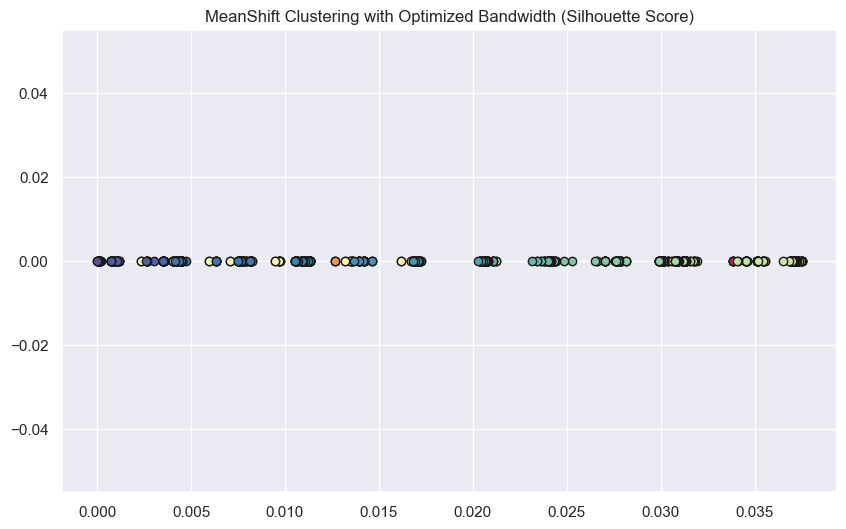

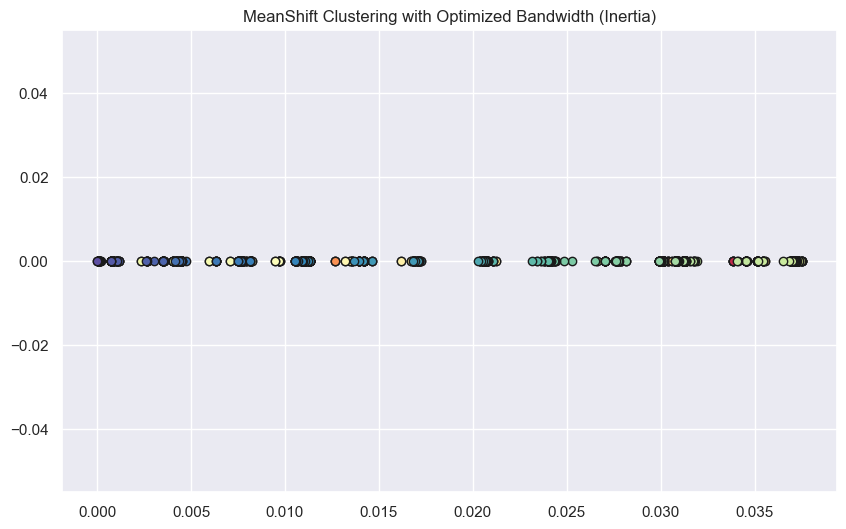

In [57]:
print(f"Best bandwidth (Silhouette Score): {best_bandwidth_silhouette}")
print(f"Best Silhouette score: {best_silhouette_score}")
print(f"Best bandwidth (Inertia): {best_bandwidth_inertia}")
print(f"Best Inertia: {best_inertia}")
print()

# Plot the Silhouette scores and Inertias
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:red'
ax1.set_xlabel('Bandwidth')
ax1.set_ylabel('Silhouette Score', color=color)
ax1.plot(bandwidths, silhouette_scores, marker='o', color=color, label='Silhouette Score')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Inertia', color=color)
ax2.plot(bandwidths, inertias, marker='x', color=color, label='Inertia')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Silhouette Score and Inertia vs. Bandwidth for MeanShift')
plt.show()

# Plot the Number of Clusters
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(bandwidths, n_clusters, marker='o', label="Number of CLusters")

ax1.set_xlabel('Bandwidth')
ax1.set_ylabel('Number of Clusters')
plt.title('MeanShift Clustering with Optimized Bandwidth (Number of Clusters)')
plt.show()

# Fit MeanShift with the best bandwidth (Silhouette Score) and plot the results
meanshift_silhouette = MeanShift(bandwidth=best_bandwidth_silhouette)
labels_silhouette = meanshift_silhouette.fit_predict(X)

plt.figure(figsize=(10, 6))
unique_labels = np.unique(labels_silhouette)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    class_member_mask = (labels_silhouette == k)
    xy = X[class_member_mask]
    plt.plot(xy, np.zeros_like(xy), 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)

plt.title('MeanShift Clustering with Optimized Bandwidth (Silhouette Score)')
plt.show()

# Fit MeanShift with the best bandwidth (Inertia) and plot the results
meanshift_inertia = MeanShift(bandwidth=best_bandwidth_inertia)
labels_inertia = meanshift_inertia.fit_predict(X)

plt.figure(figsize=(10, 6))
unique_labels = np.unique(labels_inertia)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    class_member_mask = (labels_inertia == k)
    xy = X[class_member_mask]
    plt.plot(xy, np.zeros_like(xy), 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)

plt.title('MeanShift Clustering with Optimized Bandwidth (Inertia)')
plt.show()

### Select bandwidth

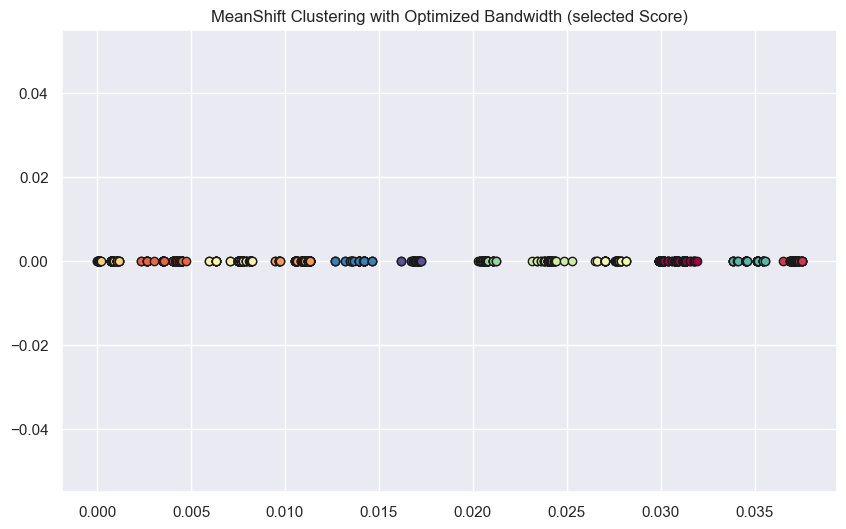

In [108]:
# Fit MeanShift with the best bandwidth (selected Score) and plot the results
meanshift_silhouette = MeanShift(bandwidth=0.00194)
labels_silhouette = meanshift_silhouette.fit_predict(X)

plt.figure(figsize=(10, 6))
unique_labels = np.unique(labels_silhouette)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    class_member_mask = (labels_silhouette == k)
    xy = X[class_member_mask]
    plt.plot(xy, np.zeros_like(xy), 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)

plt.title('MeanShift Clustering with Optimized Bandwidth (selected Score)')
plt.show()



<!-- ### Results for `bandwidths` in range: 0.001 - 0.003 - 30

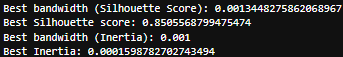

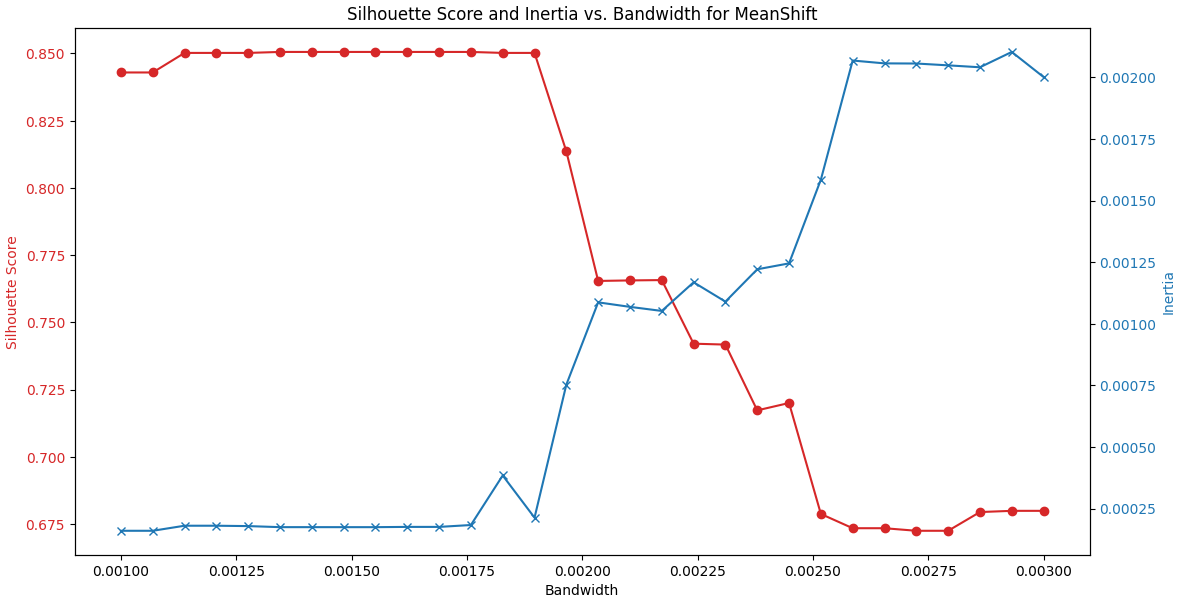

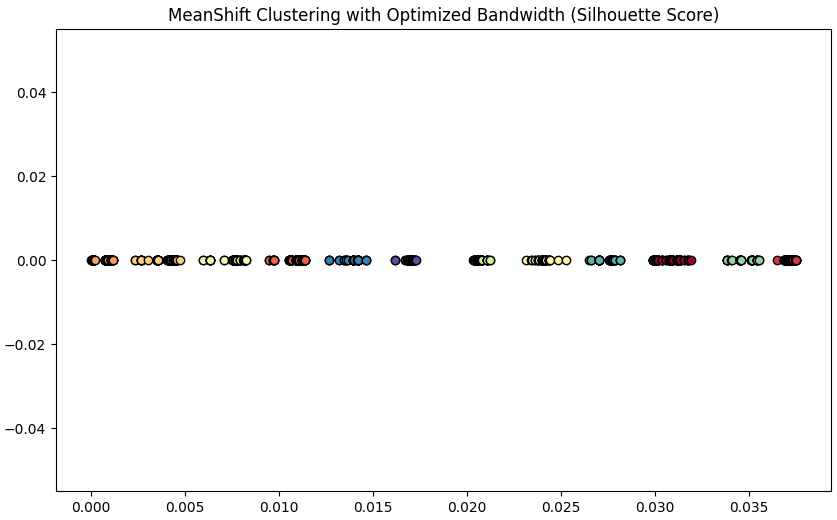

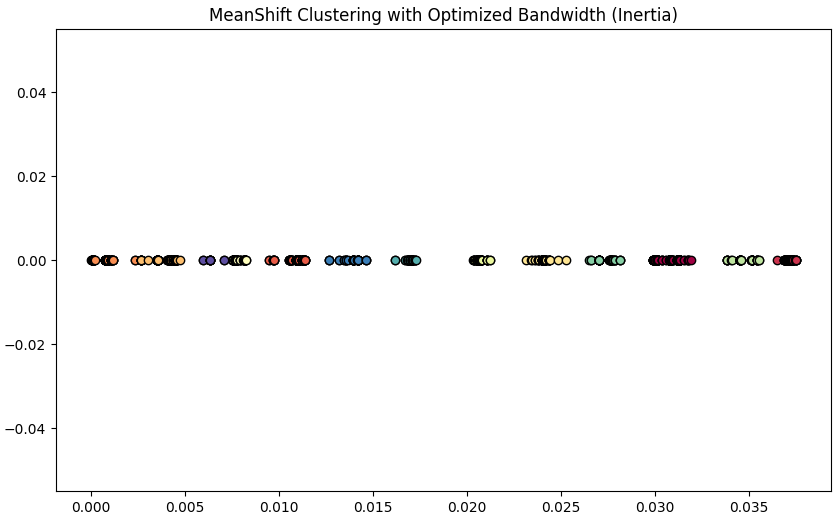
 -->
### Results for `bandwidths` in range: 0.0001 - 0.01 - 100

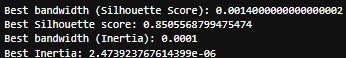

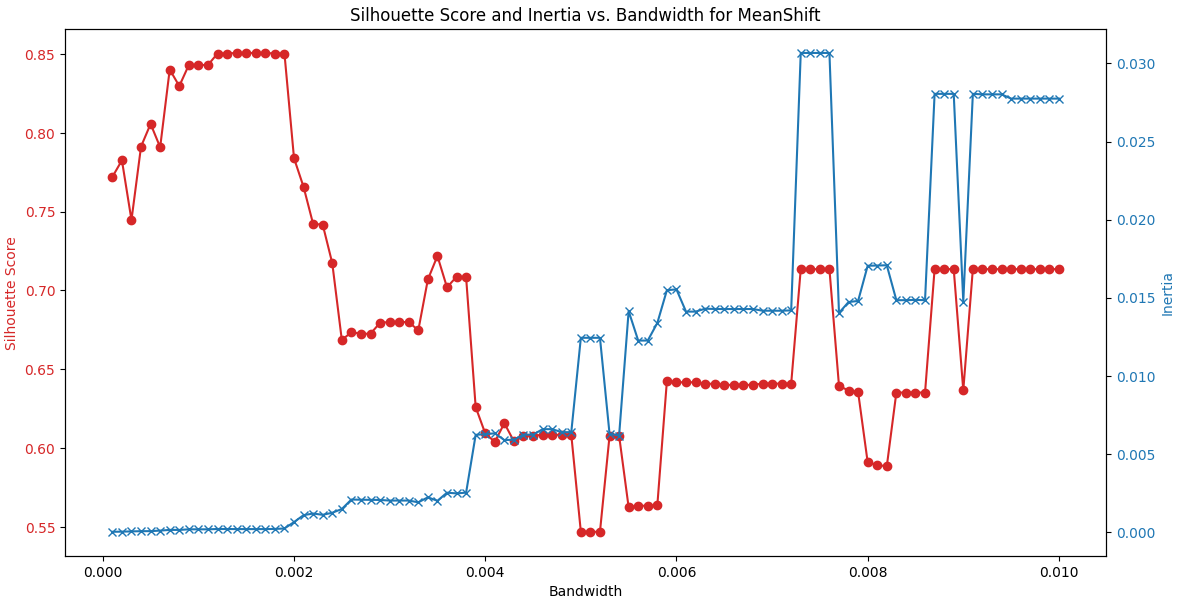

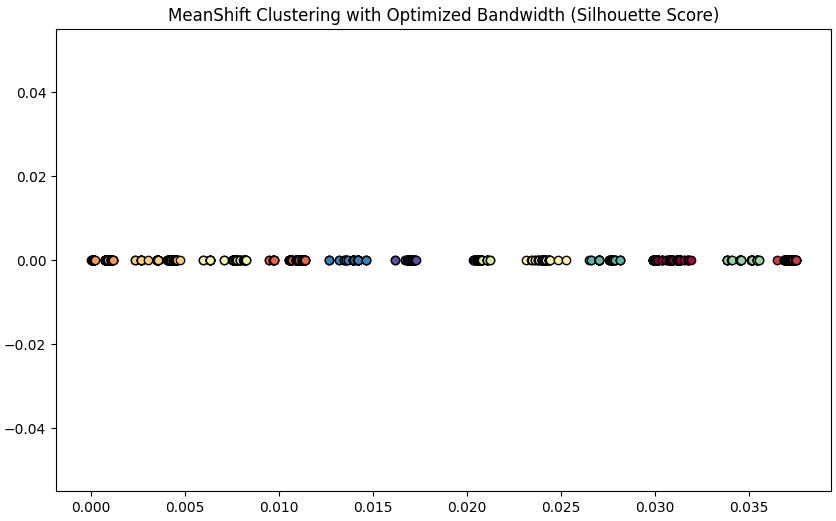

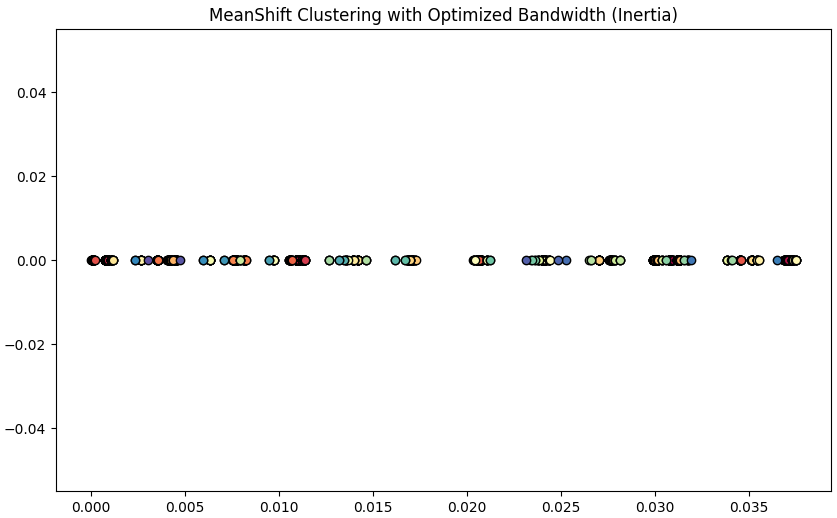

### Results for `bandwidths` in range: 0.00001 - 0.0002 - 20

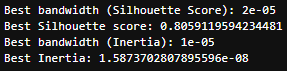

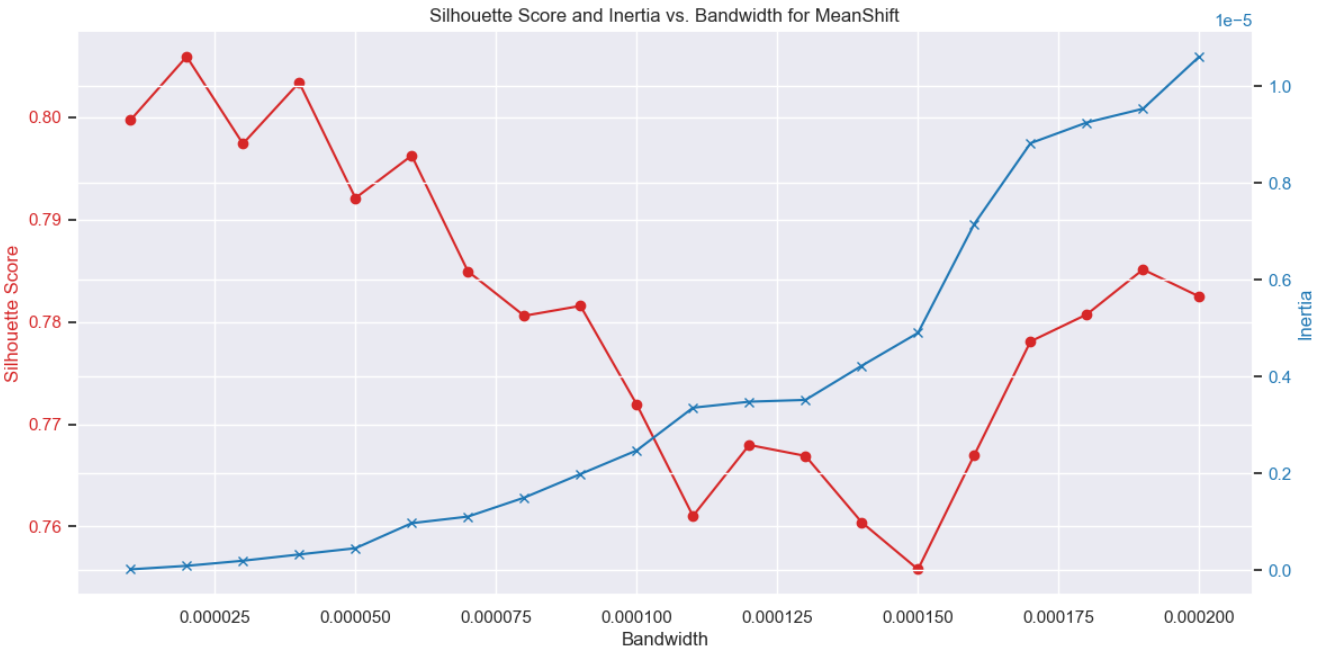

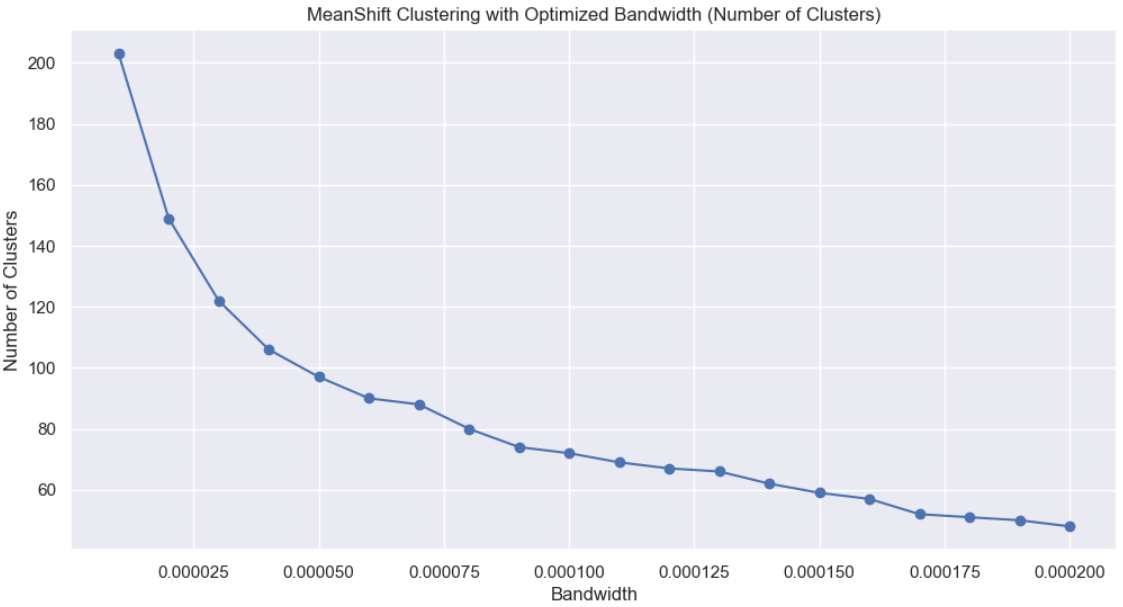

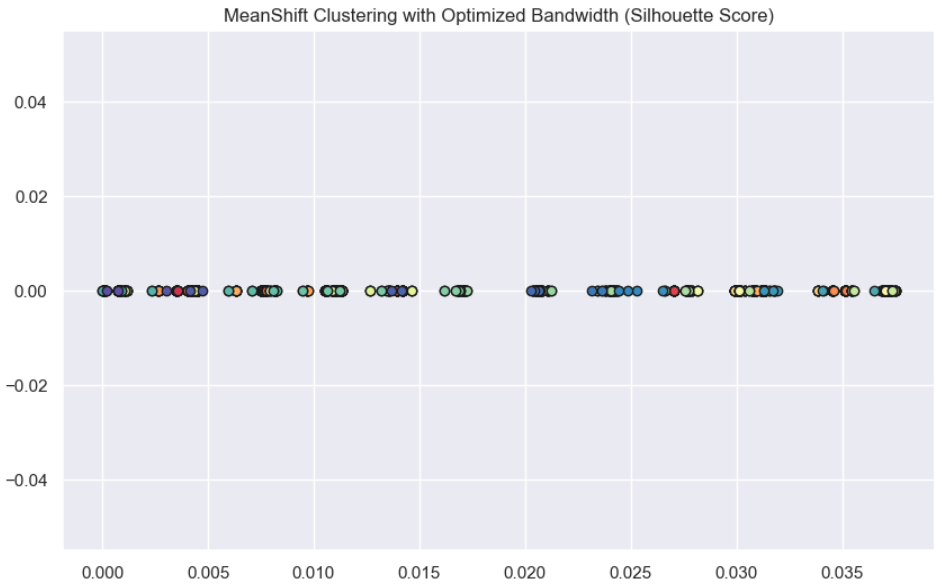

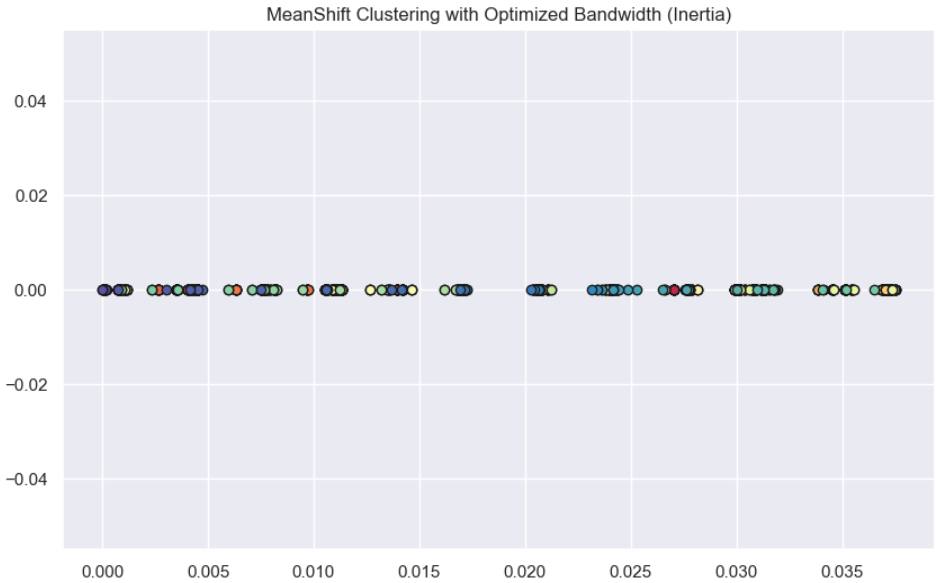

### Results for `bandwidths` in range: 0.000001 - 0.00002 - 20

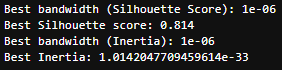

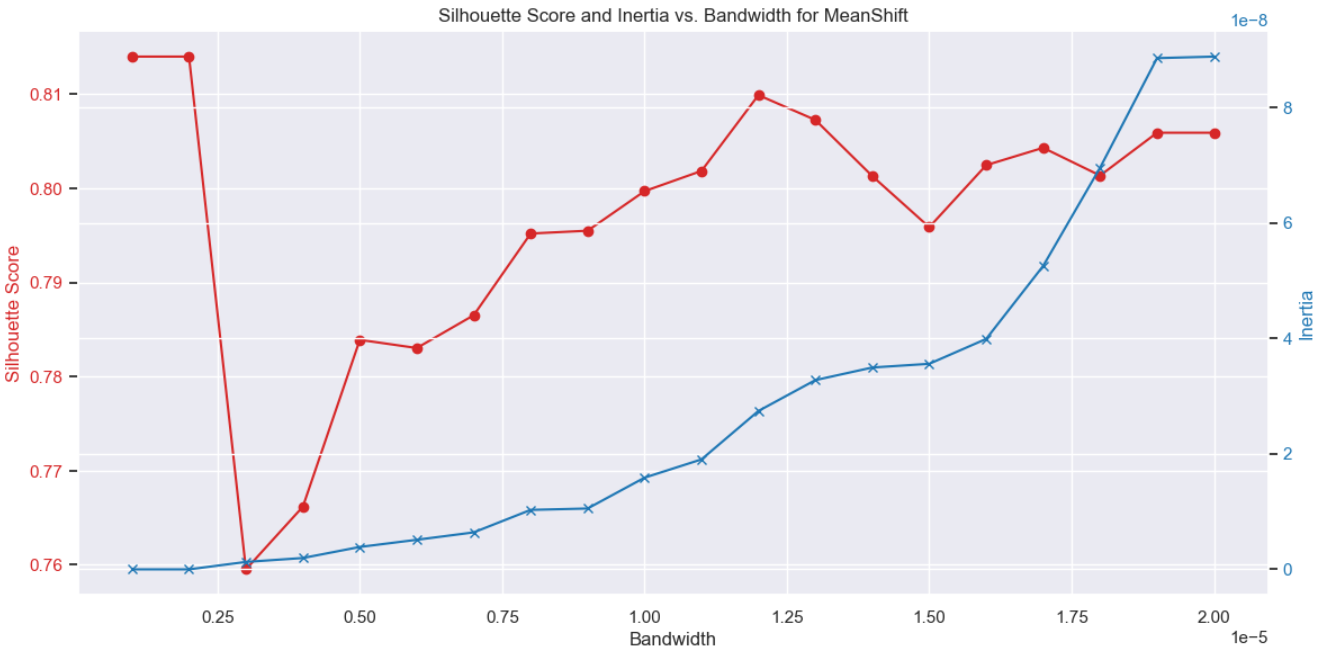

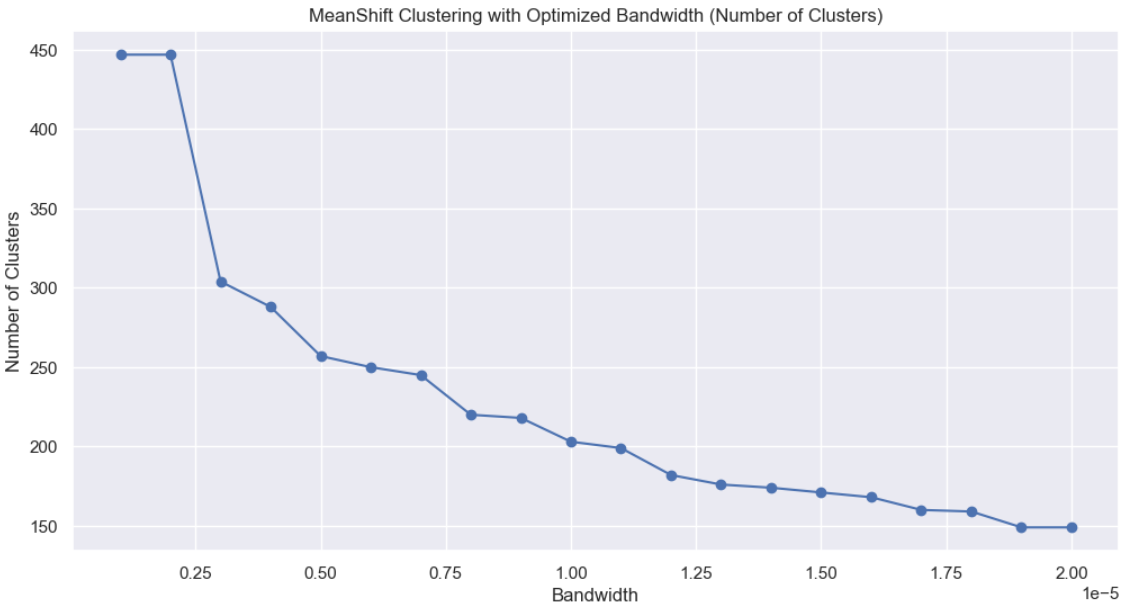

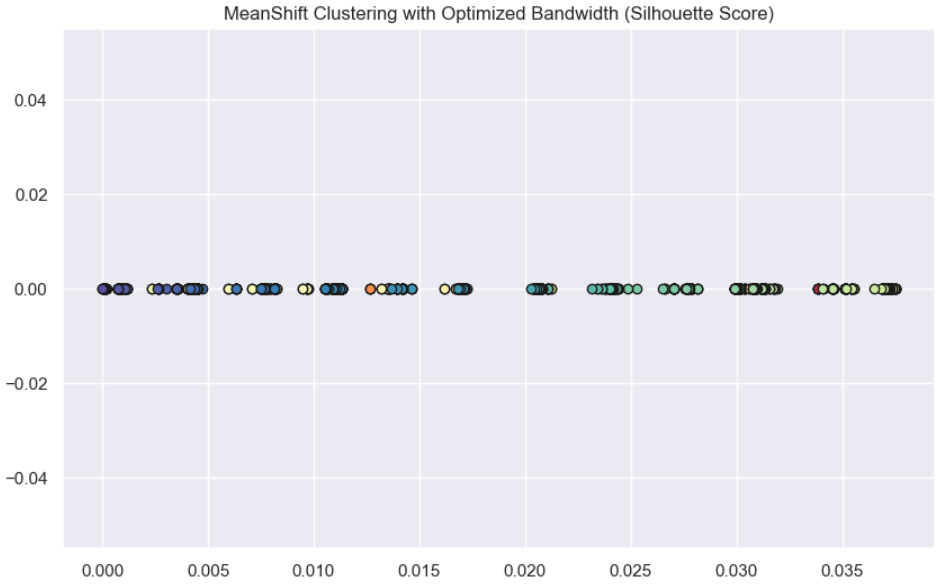

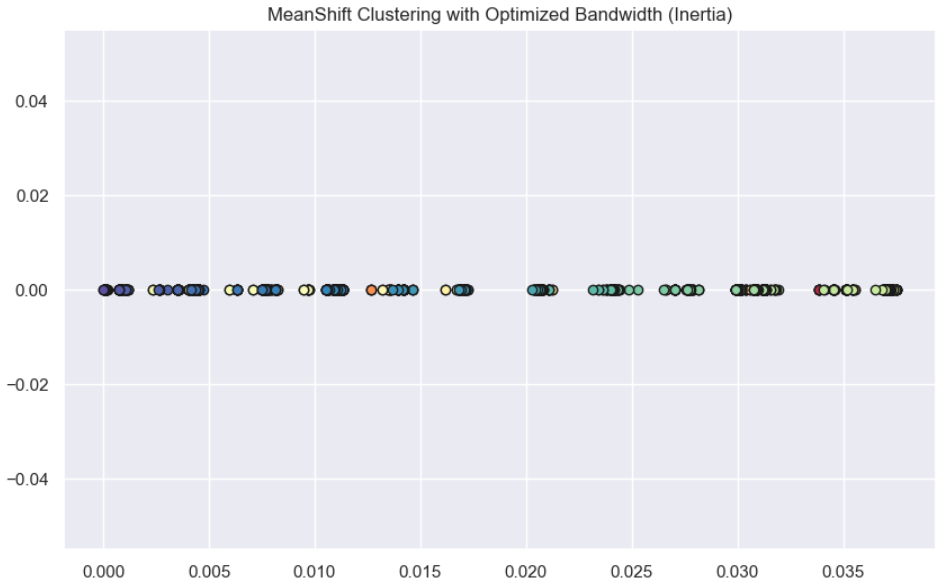

---
# Fit final model for all samples

### Fit MeanShift

In [ ]:
from time import time
from sklearn.cluster import MeanShift

bandwidth = 0.00194

meanshift = MeanShift(
    bandwidth=bandwidth,
    seeds=None,
    bin_seeding=False,
    min_bin_freq=1,
    cluster_all=True,
    n_jobs=None,
    max_iter=300,
); s = time()

meanshift.fit(df[['uuid']])

t = round(time() - s, 2)
print(f'Total seconds: {t} s')

meanshift_df = pd.Series(meanshift.labels_, index=df.index, name='label')
meanshift_df = meanshift_df.reset_index()
meanshift_df.to_csv('meanshift_pred.csv', index=False)

meanshift_df = pd.read_csv(f'meanshift_pred_{str(bandwidth).replace(".", "-")}.csv', index_col=0)
meanshift_df.head()

### Fit DBScan

In [ ]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(
    eps=0.5,
    min_samples=5,
    metric='euclidean',
    metric_params=None,
    algorithm='auto',
    leaf_size=30,
    p=None,
    n_jobs=None,
)
# dbscan.fit(df[['uuid']])

# dbscan_df = pd.Series(dbscan.labels_, index=df.index, name='label')
# dbscan_df = dbscan_df.reset_index()
# dbscan_df.to_csv('dbscan_pred.csv', index=False)

dbscan_df = pd.read_csv('dbscan_pred.csv', index_col=0)
dbscan_df